# Hopping leg

Simulation model of a 2R mechanism that interacts with environment. The mechanism can be considered as robotic leg. The script show how we can use MuJoCo to conduct a virtual experiment, adjust controller, and create some plot to examine behavior and performance of a designed robot.

In [1]:
from os import path
import mujoco
import mujoco_viewer
import numpy as np
from matplotlib import pyplot as plt

- To control the robotic leg here we are going to use a simple PD controller. 

In [2]:
def controller(mjmodel: mujoco._structs.MjModel,
               mjdata: mujoco._structs.MjData,
               ref:np.array, i: int) -> None:
    """ Simple PD controller

    Args:
        mjmodel: mujoco._structs.MjModel
        mjdata: mujoco._structs.MjData
        ref (np.array): numpy array with q and dq
        i (int): iteration step
    """
    KP = 200
    KD = 5

    for k in range(2):
        error_q  = ref[0][k][i] - mjdata.qpos[k+1] # k+1 since slider joint is passive
        error_dq = ref[1][k][i] - mjdata.qvel[k+1]
        mjdata.ctrl[k] = KP * error_q + KD * error_dq

- Here I use `mj_forward` to set initial angular position. 
- Make sure you have the same timestep in the code and in the XML model.

In [3]:
SIMEND = 10
TIMESTEP = 0.0005
STEP_NUM = int(SIMEND/TIMESTEP)
MODEL_NAME = 'closed_chain_leg_scene.xml'

ROOT = path.abspath('')
FOLDER_PATH = path.join(ROOT, '')
MODEL_PATH = path.join(FOLDER_PATH, MODEL_NAME)

model = mujoco.MjModel.from_xml_path(MODEL_PATH)
data = mujoco.MjData(model)

# set initial angles
data.qpos[1] = -0.79
data.qpos[2] = -1.57
mujoco.mj_forward(model, data)

Set reference and empty lists for measurements.

In [4]:
time = np.linspace(0, SIMEND, STEP_NUM)
freq = 2*np.pi*1
q_ref  = np.array([np.pi/12 * np.sin(freq * time) - np.pi/4,
                   -np.pi/6 * np.sin(freq * time) - np.pi/2])
dq_ref = np.array([np.pi/12 * freq * np.cos(freq * time), 
                   -np.pi/6 * freq * np.cos(freq * time)])
ref = np.array([q_ref, dq_ref])

xF_all = []
zF_all = []
q1_all = []
q2_all = []

Conduct the simulation

In [5]:
viewer = mujoco_viewer.MujocoViewer(model, data,
                                    title = "open_chain_leg",
                                    width = 1920,
                                    height = 1080)

for i in range(STEP_NUM):
    if viewer.is_alive:

        xF_all.append(data.site_xpos[0][0])
        zF_all.append(data.site_xpos[0][2])
        q1_all.append(data.qpos[1])
        q2_all.append(data.qpos[2])
        
        mujoco.set_mjcb_control(controller(model, data, ref, i))
        mujoco.mj_step(model, data)
        
        viewer.render()
    
    else:
        break

viewer.close()

Create plots and make some conclusion 

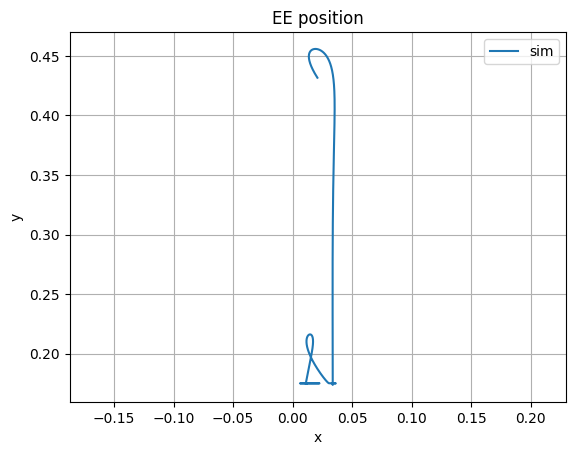

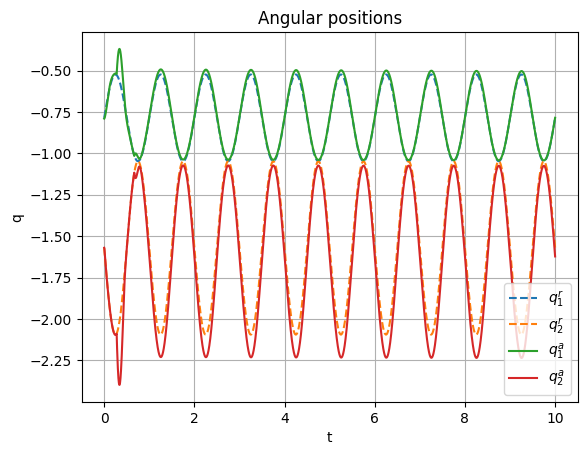

In [6]:
plt.figure(1)
plt.title("EE position")
plt.plot(xF_all, zF_all, label='sim')
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.axis('equal')
plt.grid()
plt.show(block=False)

plt.figure(2)
plt.title("Angular positions")
plt.plot(time, ref[0][0], label='$q_1^r$', linestyle="--")
plt.plot(time, ref[0][1], label='$q_2^r$', linestyle="--")
plt.plot(time, q1_all, label='$q_1^a$')
plt.plot(time, q2_all, label='$q_2^a$')
plt.ylabel("q")
plt.xlabel("t")
plt.legend()
plt.grid()
plt.show(block=False)    